In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from duckreg.estimators import DuckMundlak, DuckDoubleDemeaning
import duckdb
import pyfixest as pf

np.random.seed(42)

In [2]:
def panel_dgp(
    num_units=1000,
    num_periods=30,
    num_treated=50,
    treatment_start=15,
    hetfx=False,
    base_treatment_effect=np.repeat(0, 15),
    ar_coef=0.2,  # Autoregressive coefficient for epsilon_it
    sigma_unit=1,
    sigma_time=0.5,
    sigma_epsilon = 0.5,  # Standard deviation of epsilon_it
):
    unit_intercepts = np.random.normal(0, sigma_unit, num_units)

    # Generate day-of-the-week pattern
    day_effects = np.array([-0.1, 0.1, 0, 0, 0.1, 0.5, 0.5])  # Stronger effects on weekends
    day_pattern = np.tile(day_effects, num_periods // 7 + 1)[:num_periods]

    # Generate autoregressive structure
    ar_coef_time = 0.2
    ar_noise_time = np.random.normal(0, sigma_time, num_periods)
    time_intercepts = np.zeros(num_periods)
    time_intercepts[0] = ar_noise_time[0]
    for t in range(1, num_periods):
        time_intercepts[t] = ar_coef_time * time_intercepts[t - 1] + ar_noise_time[t]
    # Combine day-of-the-week pattern and autoregressive structure
    time_intercepts = day_pattern + time_intercepts - np.mean(time_intercepts)
    # Generate autoregressive noise for each unit
    ar_noise = np.random.normal(0, sigma_epsilon, (num_units, num_periods))
    noise = np.zeros((num_units, num_periods))
    noise[:, 0] = ar_noise[:, 0]
    for t in range(1, num_periods):
        noise[:, t] = ar_coef * noise[:, t - 1] + ar_noise[:, t]
    # N X T matrix of potential outcomes under control
    Y0 = unit_intercepts[:, np.newaxis] + time_intercepts[np.newaxis, :] + noise
    # Generate the base treatment effect (concave structure)
    # Generate heterogeneous multipliers for each unit
    if hetfx:
        heterogeneous_multipliers = np.random.uniform(0.5, 1.5, num_units)
    else:
        heterogeneous_multipliers = np.ones(num_units)

    # Create a 2D array to store the heterogeneous treatment effects
    treatment_effect = np.zeros((num_units, num_periods - treatment_start))
    for i in range(num_units):
        treatment_effect[i, :] = heterogeneous_multipliers[i] * base_treatment_effect

    # random assignment
    treated_units = np.random.choice(num_units, num_treated, replace=False)
    treatment_status = np.zeros((num_units, num_periods), dtype=bool)
    treatment_status[treated_units, treatment_start:] = True

    # Apply the heterogeneous treatment effect to the treated units
    Y1 = Y0.copy()
    for t in range(treatment_start, num_periods):
        Y1[:, t][treatment_status[:, t]] += treatment_effect[:, t - treatment_start][
            treatment_status[:, t]
        ]

    # Create a DataFrame
    unit_ids = np.repeat(np.arange(num_units), num_periods)
    time_ids = np.tile(np.arange(num_periods), num_units)
    W_it = treatment_status.flatten()
    Y_it = np.where(W_it, Y1.flatten(), Y0.flatten())
    unit_intercepts_flat = np.repeat(unit_intercepts, num_periods)
    time_intercepts_flat = np.tile(time_intercepts, num_units)
    df = pd.DataFrame(
        {
            "unit_id": unit_ids,
            "time_id": time_ids,
            "W_it": W_it.astype(int),
            "Y_it": Y_it,
            "unit_intercept": unit_intercepts_flat,
            "time_intercept": time_intercepts_flat,
        }
    )
    # assign units to ever treated if the max of W_it is 1
    df["ever_treated"] = df.groupby("unit_id")["W_it"].transform("max")
    # label cohorts
    df['cohort'] = df.query("W_it == 1").groupby('unit_id')['time_id'].transform('min')
    df['cohort'] = df['cohort'].fillna(0)
    df['cohort'] = df.groupby('unit_id')['cohort'].transform('max')
    return df

# Function to create and populate DuckDB database
def create_duckdb_database(df, db_name="large_dataset.db", table="panel_data"):
    conn = duckdb.connect(db_name)
    conn.execute(f"DROP TABLE IF EXISTS {table}")
    conn.execute(f"CREATE TABLE {table} AS SELECT * FROM df")
    conn.close()
    print(f"Data loaded into DuckDB database: {db_name}")

In [3]:
num_periods = 30
treat_start_period = 15
treat_effect_vector= 0.2 * np.log(2 * np.arange(1, num_periods - treat_start_period + 1))
treat_effect_vector[8:] = 0 # switch off effects after a week
sigma_i, sigma_t = 2, 1
treat_effect_vector.mean()

np.float64(0.21533040462966416)

In [4]:
df = panel_dgp(
    num_units=100_000, num_treated= 50_000,
    num_periods=30,
    treatment_start = treat_start_period,
    hetfx=False,
    base_treatment_effect = treat_effect_vector,
    sigma_unit = sigma_i, sigma_time = sigma_t,
)

db_name = 'event_study_data.db'
create_duckdb_database(df, db_name)
df = df.merge(
    pd.get_dummies(df["time_id"], prefix="time"), left_index=True, right_index=True
)
time_dummies = df.filter(regex = r"time_\d").columns

Data loaded into DuckDB database: event_study_data.db


### in-memory estimation

Eq 5.13 in Wooldridge

$$
Y_{it} = \alpha + \xi d_i + \beta_q(d_i fq_t) + \dots + \beta_T(d_i fT_t) + \theta_0 fq_t + \dots + \theta_T fT_t + \epsilon_{it}
$$

where $\beta$ coefficients are the event study coefficients.

In [5]:
%%time
print(ff := f"""
        Y_it ~ -1 + ever_treated*({' + '.join(time_dummies)})
         """)
m = pf.feols(ff, data = df)
m.coef().index


        Y_it ~ -1 + ever_treated*(time_0 + time_1 + time_2 + time_3 + time_4 + time_5 + time_6 + time_7 + time_8 + time_9 + time_10 + time_11 + time_12 + time_13 + time_14 + time_15 + time_16 + time_17 + time_18 + time_19 + time_20 + time_21 + time_22 + time_23 + time_24 + time_25 + time_26 + time_27 + time_28 + time_29)
         


/home/alal/Desktop/duckreg/.venv/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:1987: UserWarning: 
            The following variables are collinear: ['time_29'].
            The variables are dropped from the model.
            
  warnings.warn(


CPU times: user 5.4 s, sys: 1.56 s, total: 6.96 s
Wall time: 4.14 s


/home/alal/Desktop/duckreg/.venv/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:646: RuntimeWarning: invalid value encountered in sqrt
  self._se = np.sqrt(np.diagonal(_vcov))


Index(['Intercept', 'ever_treated', 'time_0', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19', 'time_20', 'time_21', 'time_22',
       'time_23', 'time_24', 'time_25', 'time_26', 'time_27', 'time_28',
       'ever_treated:time_0', 'ever_treated:time_1', 'ever_treated:time_2',
       'ever_treated:time_3', 'ever_treated:time_4', 'ever_treated:time_5',
       'ever_treated:time_6', 'ever_treated:time_7', 'ever_treated:time_8',
       'ever_treated:time_9', 'ever_treated:time_10', 'ever_treated:time_11',
       'ever_treated:time_12', 'ever_treated:time_13', 'ever_treated:time_14',
       'ever_treated:time_15', 'ever_treated:time_16', 'ever_treated:time_17',
       'ever_treated:time_18', 'ever_treated:time_19', 'ever_treated:time_20',
       'ever_treated:time_21', 'ever_treated:time_22', 'ever_treated:time_23',
     

Event study regression

In [6]:
%%time
m2 = pf.feols("""
              Y_it ~ i(time_id, ever_treated,  ref = 14) |
                unit_id + time_id
              """,
              df
             )
evstudy_coefs = m2.coef().values
# insert zero in reference period
evstudy_coefs = np.insert(evstudy_coefs, 14, 0)

CPU times: user 17.9 s, sys: 2.14 s, total: 20 s
Wall time: 9.96 s


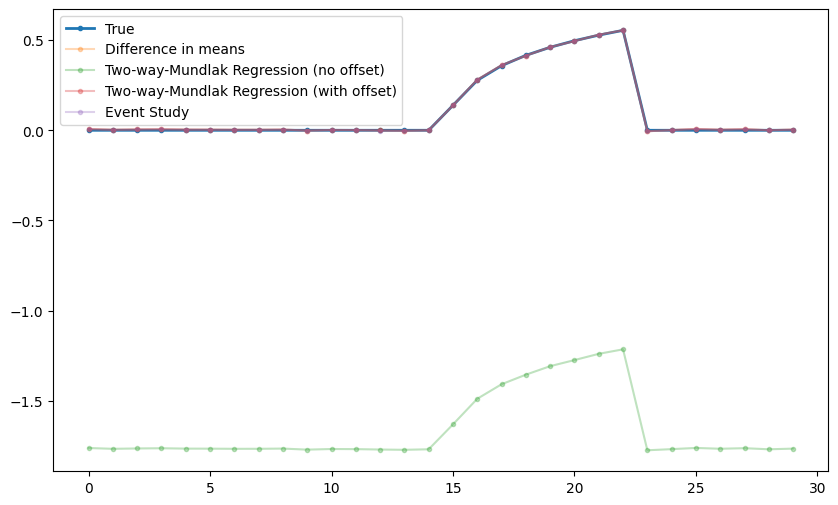

In [7]:
p0 = np.r_[np.zeros(15), treat_effect_vector]
p1 = m.coef().filter(regex=r"ever_treated:time_\d").values


p2 = (
    df.groupby(["ever_treated", "time_id"])["Y_it"]
    .mean()
    .unstack()
    .diff(axis=0)
    .iloc[1, :]
    .values
)
f, ax = plt.subplots(figsize = (10, 6))
ax.plot(p0, marker=".", label="True", linewidth=2)
ax.plot(p2, marker=".", alpha=0.3, label="Difference in means")
ax.plot(p1, marker=".", alpha=0.3, label="Two-way-Mundlak Regression (no offset)")
ax.plot(
    p1 + m.coef().filter(regex="ever_treated$").values,
    marker=".",
    alpha=0.3,
    label="Two-way-Mundlak Regression (with offset)",
)
ax.plot(evstudy_coefs, marker=".", alpha=0.3, label="Event Study")
ax.legend()

We get the same coefficient once we offset the $\beta$ vector with $\xi$. The wooldridge paper claims that the $\beta$ coefficients should be identical to the event study coefficients without the $\xi$ offset. This is not true. 

So, the gameplan is to groupby (`on_hot_encoded_cohort_id, one_hot_encoded_time_id, on_hot_encoded_cohort_id X one_hot_encoded_time_id`) and run the compressed regression by weighted least squares.

### compress (in pandas for now)

In [8]:
%%time
cohort_dummies = pd.get_dummies(df['cohort'], drop_first=True).astype(int).values
time_dummies = pd.get_dummies(df['time_id']).astype(int).values

# cohort dummies, time dummies, and interaction
Xmat = np.c_[
    np.ones(df.shape[0]),
    cohort_dummies,
    cohort_dummies[:, [0]] * time_dummies,
    time_dummies,
]
y = df["Y_it"].values
dfnew = pd.DataFrame(
    np.c_[y, Xmat], columns=["Y_it"] + [f"X{i}" for i in range(Xmat.shape[1])]
)
# collapse to strata level
agg_df = dfnew.groupby(list(dfnew.columns[1:]))['Y_it'].agg(['sum', 'count']).reset_index()
agg_df['y_mean'] = agg_df['sum'] / agg_df['count']
agg_df.shape

CPU times: user 2.54 s, sys: 992 ms, total: 3.53 s
Wall time: 3.54 s


(60, 65)

In [9]:
%%time
print(ff := f"y_mean~0+{'+'.join(dfnew.filter(like = 'X').columns)}")
m_agg = pf.feols(ff, data = agg_df, weights = 'count', weights_type='fweights')
coefs = m_agg.coef()
compressed_coefs = coefs.iloc[2:31] + coefs['X1']

y_mean~0+X0+X1+X2+X3+X4+X5+X6+X7+X8+X9+X10+X11+X12+X13+X14+X15+X16+X17+X18+X19+X20+X21+X22+X23+X24+X25+X26+X27+X28+X29+X30+X31+X32+X33+X34+X35+X36+X37+X38+X39+X40+X41+X42+X43+X44+X45+X46+X47+X48+X49+X50+X51+X52+X53+X54+X55+X56+X57+X58+X59+X60+X61
CPU times: user 205 ms, sys: 219 ms, total: 423 ms
Wall time: 423 ms


/home/alal/Desktop/duckreg/.venv/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:1987: UserWarning: 
            The following variables are collinear: ['X0', 'X31', 'X61'].
            The variables are dropped from the model.
            
  warnings.warn(


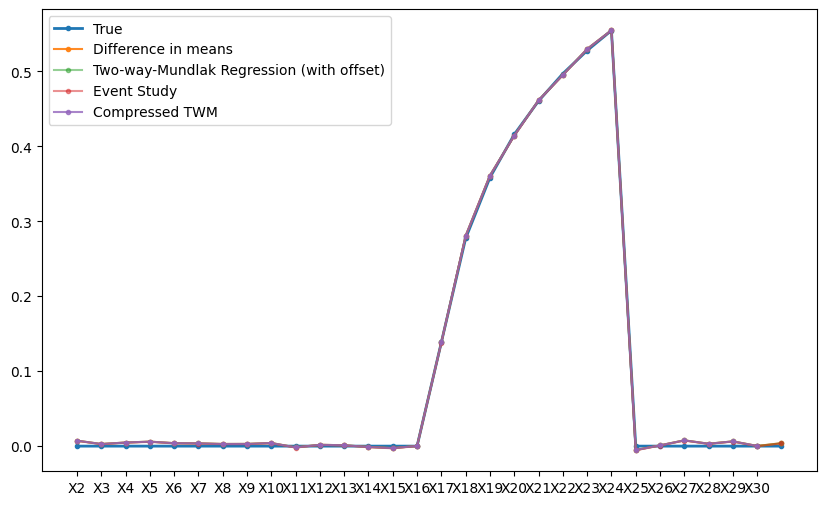

In [10]:
p0 = np.r_[np.zeros(15), treat_effect_vector]
p1 = m.coef().filter(regex=r"ever_treated:time_\d").values
p2 = (
    df.groupby(["ever_treated", "time_id"])["Y_it"]
    .mean()
    .unstack()
    .diff(axis=0)
    .iloc[1, :]
    .values
)

f, ax = plt.subplots(figsize=(10, 6))
ax.plot(p0, marker=".", label="True", linewidth=2)
ax.plot(p2, marker=".", alpha=0.9, label="Difference in means")
ax.plot(
    p1 + m.coef().filter(regex="ever_treated$").values,
    marker=".",
    alpha=0.5,
    label="Two-way-Mundlak Regression (with offset)",
)
ax.plot(evstudy_coefs, marker=".", alpha=0.5, label="Event Study")
ax.plot(compressed_coefs, marker=".", alpha=0.8, label="Compressed TWM")
ax.legend()

We recover the event study coefficients with compressed data. Now, we need implement the one-hot-encoding steps above in duckdb.

## Multiple cohorts

In [15]:
def panel_dgp_stagg(
    num_units=100,
    num_periods=30,
    num_treated=[50],
    treatment_start_cohorts=[15],
    sigma_unit=1,
    sigma_time=0.5,
    sigma_epsilon=.2,
    hetfx=False,
    base_treatment_effects=[0.1 * np.log(np.arange(1, 30 - 15 + 1))],
    return_dataframe=True,
    ar_coef=0.8,
):
    # unit FEs
    unit_intercepts = np.random.normal(0, sigma_unit, num_units)
    ####################################################################
    # time FEs: Generate day-of-the-week pattern
    day_effects = np.array([-0.1, 0.1, 0, 0, 0.1, 0.5, 0.5])  # Stronger effects on weekends
    day_pattern = np.tile(day_effects, num_periods // 7 + 1)[:num_periods]
    # autoregressive structure in time FEs
    ar_coef_time = 0.2
    ar_noise_time = np.random.normal(0, sigma_time, num_periods)
    time_intercepts = np.zeros(num_periods)
    time_intercepts[0] = ar_noise_time[0]
    for t in range(1, num_periods):
        time_intercepts[t] = ar_coef_time * time_intercepts[t - 1] + ar_noise_time[t]
    # Combine day-of-the-week pattern and autoregressive structure
    time_intercepts = day_pattern + time_intercepts - np.mean(time_intercepts)
    ####################################################################
    # Generate autoregressive noise for each unit
    ar_noise = np.random.normal(0, sigma_epsilon, (num_units, num_periods))
    noise = np.zeros((num_units, num_periods))
    noise[:, 0] = ar_noise[:, 0]
    for t in range(1, num_periods):
        noise[:, t] = ar_coef * noise[:, t - 1] + ar_noise[:, t]
    # N X T matrix of potential outcomes under control
    Y0 = unit_intercepts[:, np.newaxis] + time_intercepts[np.newaxis, :] + noise
    ####################################################################
    # Generate heterogeneous multipliers for each unit
    if hetfx:
        heterogeneous_multipliers = np.random.uniform(0.5, 1.5, num_units)
    else:
        heterogeneous_multipliers = np.ones(num_units)
    # random assignment
    treated_units = np.array([], dtype=int)
    treatment_status = np.zeros((num_units, num_periods), dtype=bool)
    ####################################################################
    # Create a 2D array to store the heterogeneous treatment effects
    treatment_effect = np.zeros((num_units, num_periods))
    # iterate over treatment cohorts
    for cohort_idx, (treatment_start, num_treated_cohort) in enumerate(zip(treatment_start_cohorts, num_treated)):
        base_treatment_effect = base_treatment_effects[cohort_idx]
        cohort_treatment_effect = np.zeros((num_units, num_periods - treatment_start))

        for i in range(num_units):
            cohort_treatment_effect[i, :] = heterogeneous_multipliers[i] * base_treatment_effect
        cohort_treated_units = np.random.choice(
            np.setdiff1d(np.arange(num_units), treated_units),
            num_treated_cohort,
            replace=False,
        )
        treated_units = np.concatenate((treated_units, cohort_treated_units))
        treatment_status[cohort_treated_units, treatment_start:] = True
        treatment_effect[cohort_treated_units, treatment_start:] += cohort_treatment_effect[cohort_treated_units, :]

    # Apply the heterogeneous treatment effect to the treated units
    Y1 = Y0.copy()
    Y1[treatment_status] += treatment_effect[treatment_status]
    ####################################################################
    result = {
        "Y1": Y1,
        "Y0": Y0,
        "W": treatment_status,
        "unit_intercepts": unit_intercepts,
        "time_intercepts": time_intercepts,
    }

    if return_dataframe:
        # Create a DataFrame
        unit_ids = np.repeat(np.arange(num_units), num_periods)
        time_ids = np.tile(np.arange(num_periods), num_units)
        W_it = treatment_status.flatten()
        Y_it = np.where(W_it, Y1.flatten(), Y0.flatten())
        unit_intercepts_flat = np.repeat(unit_intercepts, num_periods)
        time_intercepts_flat = np.tile(time_intercepts, num_units)
        df = pd.DataFrame(
            {
                "unit_id": unit_ids,
                "time_id": time_ids,
                "W_it": W_it,
                "Y_it": Y_it,
                "unit_intercept": unit_intercepts_flat,
                "time_intercept": time_intercepts_flat,
            }
        )
        result["dataframe"] = df
    return result

Effect functions:
+ Cohort 1: mean reversal: big bump that decays to zero within 10 days, then zero
+ Cohort 2: shark-fin - logarithmic for the first week, then 0
+ Cohort 3: sinusoidal 

In [16]:
num_periods = 30
treatment_start_cohorts = [10, 15, 20]
num_treated_units = [25, 50, 25]

# effect functions
treat_effect_vector_1 = np.log(2 * np.arange(1, num_periods - treatment_start_cohorts[1]+ 1))
treat_effect_vector_1[8:] = 0  # switch off effects after a week
base_treatment_effects = [
    np.r_[np.linspace(2, 0, num_periods - treatment_start_cohorts[0] - 10), np.repeat(0, 10)],
    treat_effect_vector_1,
    np.sin(np.arange(1, num_periods - treatment_start_cohorts[2] + 1))  # Treatment effect function for cohort 2
]

sigma_i, sigma_t = 2, 1
sigma_epsilon=1
dgp = panel_dgp_stagg(
    num_units=200, num_treated=num_treated_units,
    num_periods=num_periods,
    treatment_start_cohorts = treatment_start_cohorts, hetfx=False,
    base_treatment_effects= base_treatment_effects,
    sigma_unit = sigma_i, sigma_time = sigma_t,
    sigma_epsilon=sigma_epsilon,
)
Y0, Y1, W, df = dgp["Y0"], dgp["Y1"], dgp["W"], dgp["dataframe"]

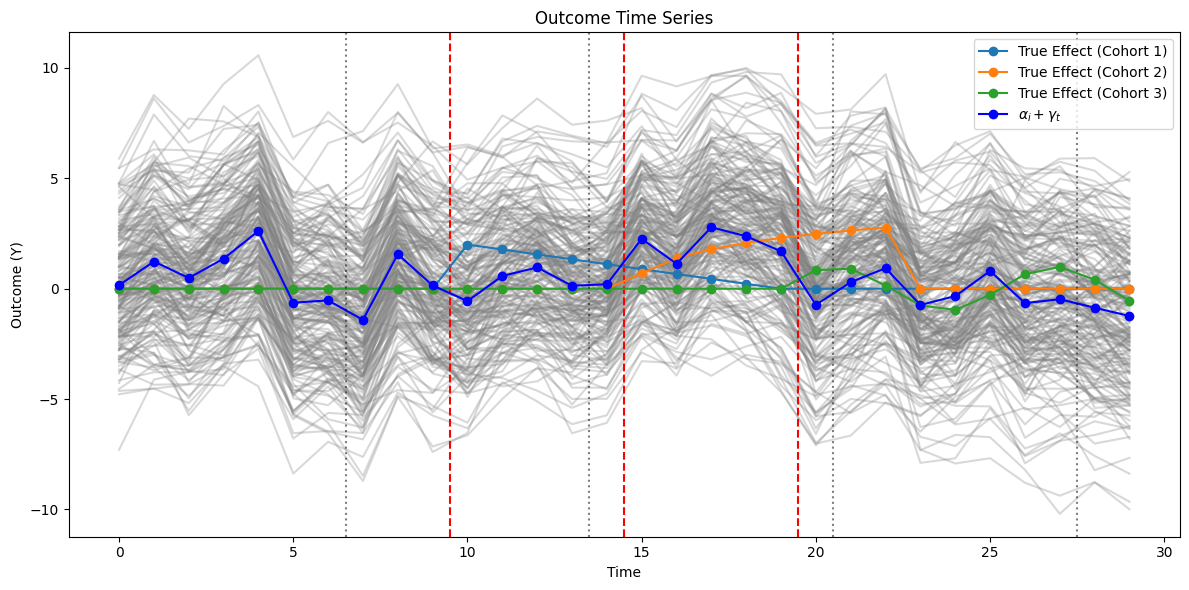

In [17]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the raw time series data for each unit
for unit_id in range(Y0.shape[0]):
    Y = (1 - W[unit_id]) * Y0[unit_id] + W[unit_id] * Y1[unit_id]
    ax.plot(Y, alpha=0.3, color = 'grey')
# Add vertical lines to indicate treatment start for each cohort
for cohort_start in treatment_start_cohorts:
    ax.axvline(x=cohort_start - 0.5, color='red', linestyle='--')
# Plot the true treatment effect functions for each cohort
for cohort_idx, cohort_start in enumerate(treatment_start_cohorts):
    effect_vector = base_treatment_effects[cohort_idx]
    effect_vector_padded = np.zeros(num_periods)
    effect_vector_padded[cohort_start:cohort_start+len(effect_vector)] = effect_vector
    ax.plot(effect_vector_padded, marker="o", label=f"True Effect (Cohort {cohort_idx + 1})")

ax.plot(Y0.mean(0), color='b', marker='o', label=r"$\alpha_i + \gamma_t$")

# Overlay week dotted lines
for week in range(1, num_periods // 7 + 1):
    ax.axvline(x=week * 7 - 0.5, color='k', linestyle=':', alpha=0.5)

# Add labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Outcome (Y)")
ax.set_title("Outcome Time Series")

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

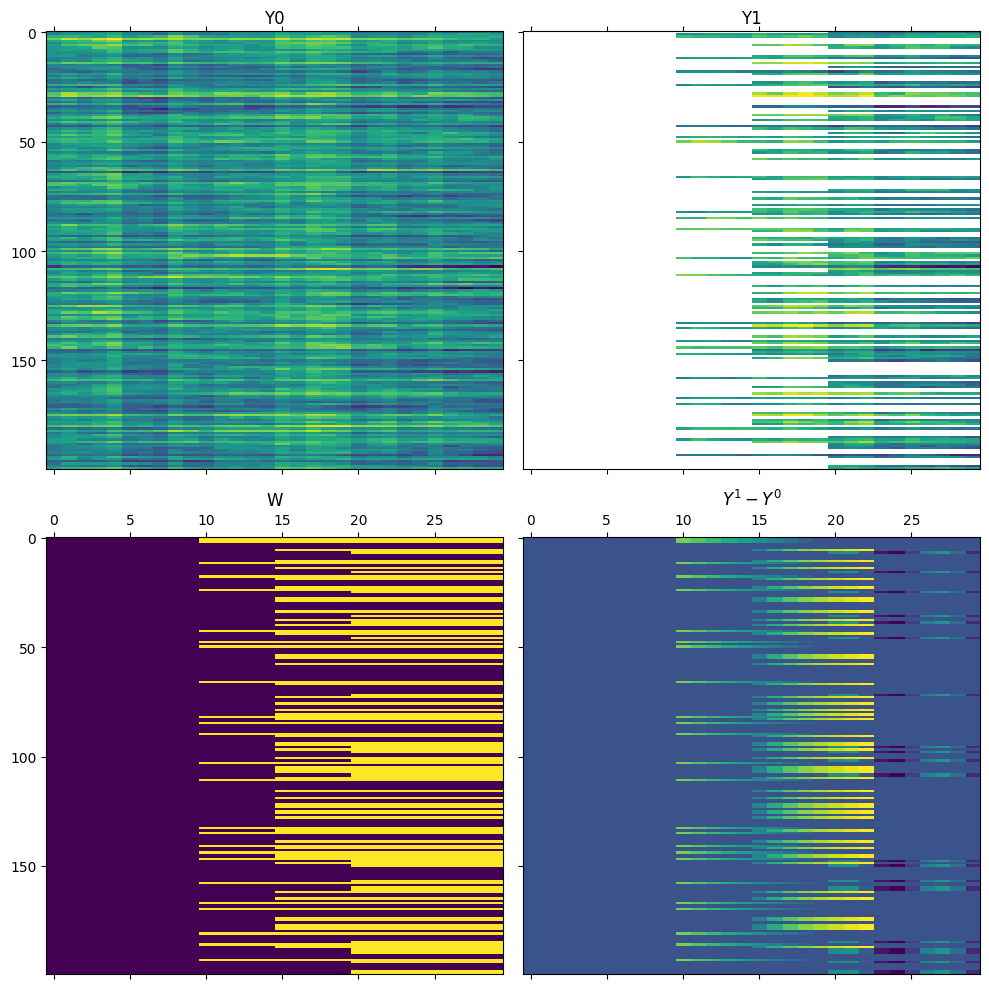

In [18]:
f, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0][0].matshow(np.ma.array(Y0), aspect='auto')
ax[0][0].set_title("Y0")
ax[0][1].matshow(np.ma.array(Y1, mask = 1-W), aspect='auto')
ax[0][1].set_title("Y1")
ax[1][0].matshow(W == 1, aspect='auto')
ax[1][0].set_title("W")
cax = ax[1][1].matshow(Y1 - Y0, aspect='auto')
ax[1][1].set_title(r"$Y^1 - Y^0$")
# f.colorbar(cax, pad=0.2)
f.tight_layout()
plt.show()

In [20]:
df = dgp['dataframe']
# create ever_treated column which takes value 1 if unit has ever been treated
df['ever_treated'] = df.groupby('unit_id')['W_it'].transform('max')
# generate first time period under treatment for each unit
df = df.merge(
  df.assign(first_treated_period = df['time_id'] * df['W_it']).groupby('unit_id')['first_treated_period'].apply(lambda x: x[x > 0].min()),
  on='unit_id')
df['rel_year'] = df['time_id'] - df['first_treated_period']
# replace NaN values with Inf
df['first_treated_period'] = df['first_treated_period'].replace(np.nan, 0).astype("int")
df['rel_year'] = df['rel_year'].replace(np.nan, np.inf)

cohort_dummies = pd.get_dummies(df.first_treated_period, drop_first = True, prefix = "cohort_dummy")
df_int = pd.concat([df, cohort_dummies], axis = 1)

In [35]:
m2 = pf.feols("Y_it ~ i(rel_year, ref = -1.0) | unit_id + time_id", df,
                 vcov = {"CRV1": "unit_id"})
m_did2s = pf.did.estimation.did2s(
    df,
    yname="Y_it",
    first_stage="~ 0 | unit_id + time_id",
    second_stage="~i(rel_year,ref=-1.0)",
    treatment="W_it",
    cluster="unit_id",
)


/home/alal/Desktop/duckreg/.venv/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:1987: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.inf]'].
            The variables are dropped from the model.
            
  warnings.warn(


In [49]:
pf.iplot([m2,
          m_did2s,
          ],
          xintercept=18.5,
          yintercept=0,
          figsize=[1200, 400],
          plot_backend="lets_plot", coord_flip=False, )

In [57]:
print(
    ff := f"""
              Y_it ~
              {'+'.join([f"i(rel_year, {x}, ref = -1.0)" for x in df_int.filter(like = "cohort_dummy", axis = 1).columns])}
              | unit_id + time_id
              """ # programmatically create all event X treatment interactions interacted with cohort
)
m3 = pf.feols(ff, df_int,
                 vcov = {"CRV1": "unit_id"})
res = m3.tidy()
# create a dict with cohort specific effect curves
res_dict = {}
for c in cohort_dummies.columns:
  res_cohort = res.filter(like = c, axis = 0)
  event_time = res_cohort.index.str.extract(r'\[T\.(-?\d+\.\d+)\]').astype(float).values.flatten()
  res_dict[c] = {
    'est': res_cohort, 'time': event_time
  }

res.sample(10)


              Y_it ~
              i(rel_year, cohort_dummy_10, ref = -1.0)+i(rel_year, cohort_dummy_15, ref = -1.0)+i(rel_year, cohort_dummy_20, ref = -1.0)
              | unit_id + time_id
              


/home/alal/Desktop/duckreg/.venv/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:1987: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.-20.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-19.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-18.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-17.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-16.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-15.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-14.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-13.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-12.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-11.0]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.inf]:cohort_dummy_10', 'C(rel_year, contr.treatment(base=-1.0))[T.-20.0]:cohort_dummy_15', 'C(rel_year, contr.tre

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
"C(rel_year, contr.treatment(base=-1.0))[T.-16.0]:cohort_dummy_20",-0.270728,0.482886,-0.560646,5.756696e-01,-1.222959,0.681502
"C(rel_year, contr.treatment(base=-1.0))[T.10.0]:cohort_dummy_15",0.206339,0.409249,0.504189,6.146867e-01,-0.600683,1.013360
"C(rel_year, contr.treatment(base=-1.0))[T.5.0]:cohort_dummy_15",2.573325,0.347956,7.395543,3.842704e-12,1.887171,3.259480
"C(rel_year, contr.treatment(base=-1.0))[T.-13.0]:cohort_dummy_20",-0.319648,0.467241,-0.684118,4.946967e-01,-1.241027,0.601731
"C(rel_year, contr.treatment(base=-1.0))[T.-2.0]:cohort_dummy_20",-0.115215,0.233877,-0.492633,6.228149e-01,-0.576410,0.345979
"C(rel_year, contr.treatment(base=-1.0))[T.-9.0]:cohort_dummy_20",-0.040965,0.482986,-0.084816,9.324928e-01,-0.993392,0.911462
"C(rel_year, contr.treatment(base=-1.0))[T.6.0]:cohort_dummy_15",2.806033,0.368064,7.623770,9.880985e-13,2.080227,3.531839
"C(rel_year, contr.treatment(base=-1.0))[T.-7.0]:cohort_dummy_10",-0.795139,0.459648,-1.729886,8.520118e-02,-1.701545,0.111267
"C(rel_year, contr.treatment(base=-1.0))[T.-8.0]:cohort_dummy_10",-0.647257,0.466537,-1.387365,1.668822e-01,-1.567248,0.272734


/tmp/ipykernel_795918/1522635039.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['rel_time'] = df_tmp['time_id'] - j
/tmp/ipykernel_795918/1522635039.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['rel_time'] = df_tmp['time_id'] - j
/tmp/ipykernel_795918/1522635039.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

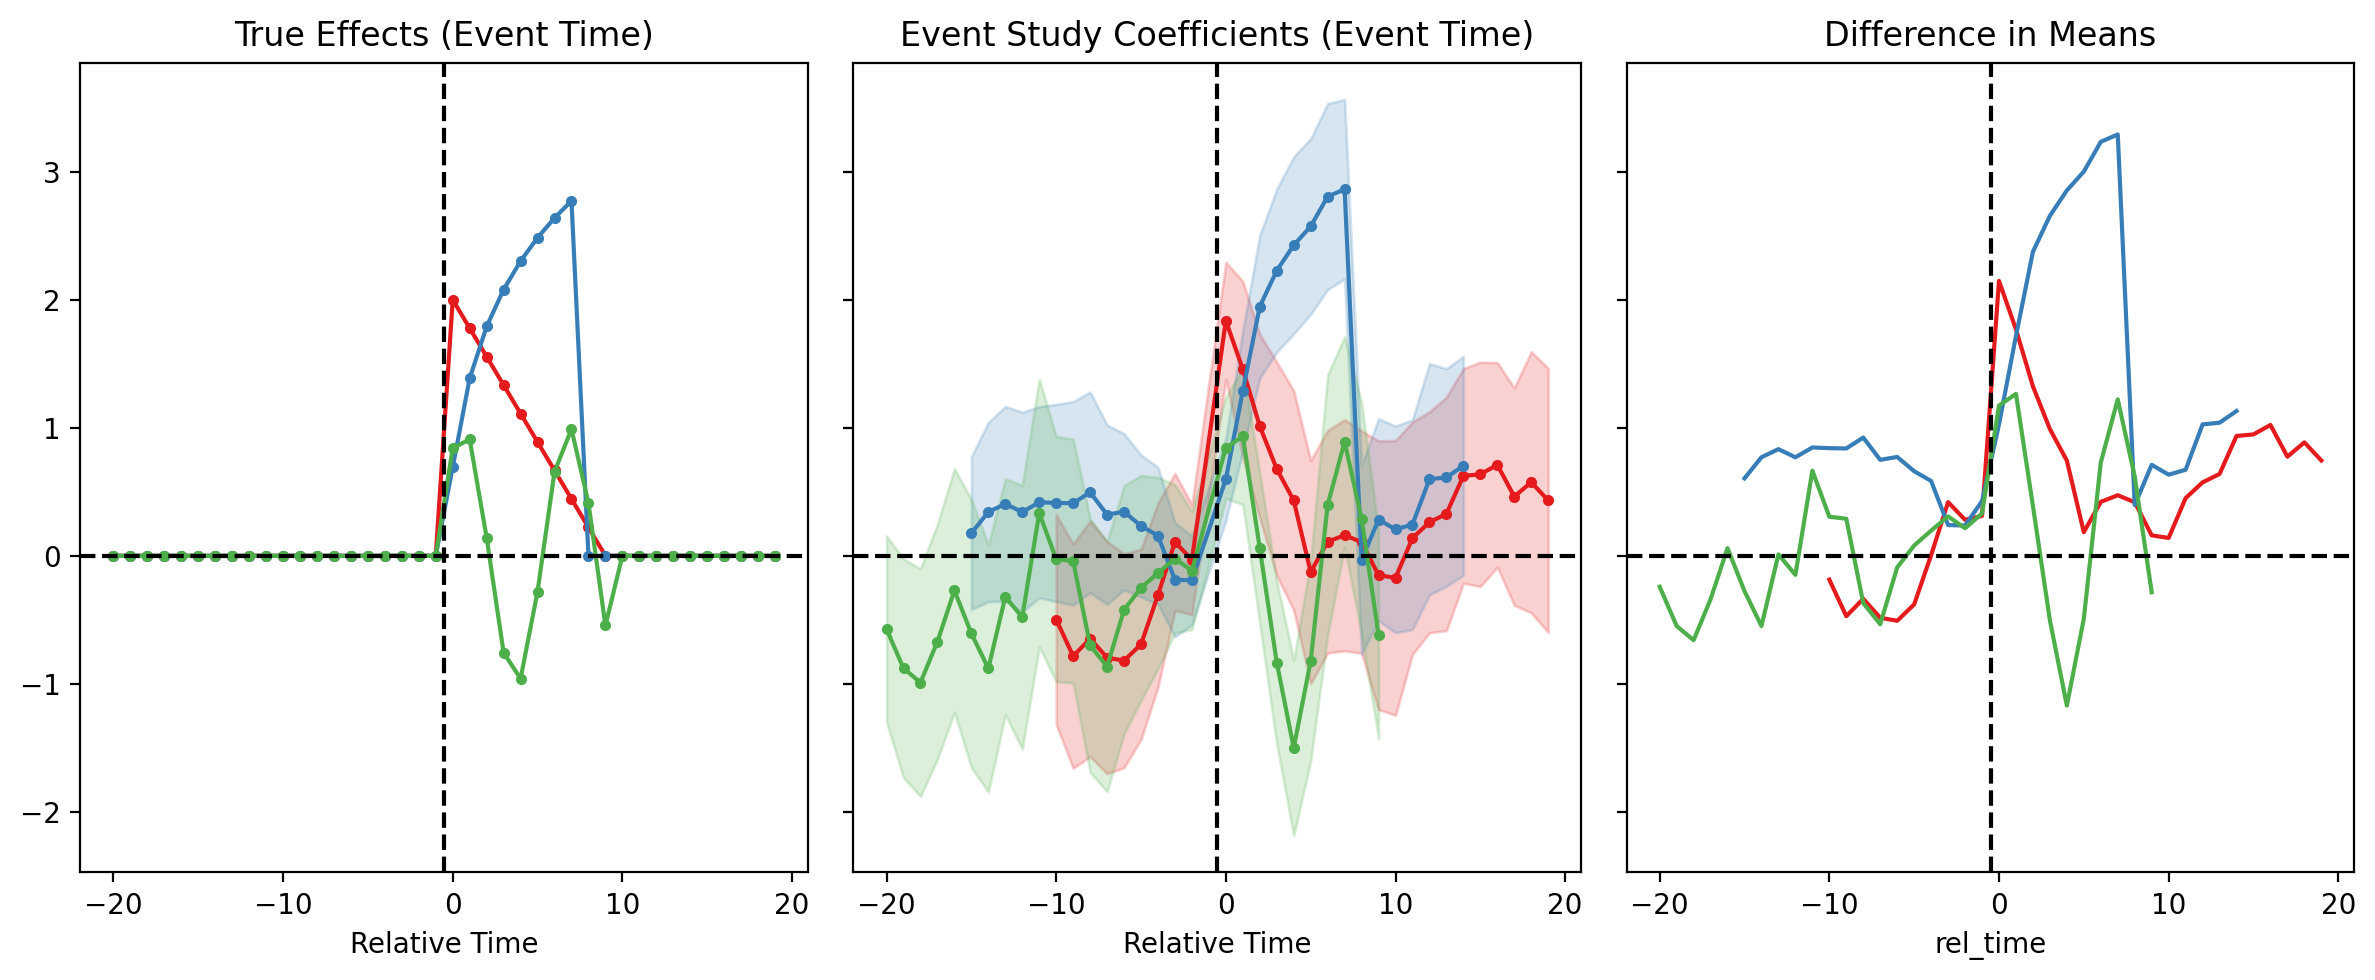

In [55]:
f, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True, dpi=200)

cmp = plt.get_cmap("Set1")

max_effect_length = max(len(effect) for effect in base_treatment_effects)
event_time = np.arange(-max(treatment_start_cohorts), max_effect_length)

i = 0
for cohort_idx, cohort_start in enumerate(treatment_start_cohorts):
    effect_vector = base_treatment_effects[cohort_idx]
    effect_vector_padded = np.zeros(len(event_time))
    start_idx = np.where(event_time == 0)[0][0]
    effect_vector_padded[start_idx:start_idx+len(effect_vector)] = effect_vector
    ax[0].plot(event_time, effect_vector_padded, marker=".", label=f"True Effect (Cohort {cohort_idx + 1})", color=cmp(i))
    i += 1

ax[0].set_title("True Effects (Event Time)")
ax[0].set_xlabel("Relative Time")


i = 0
for k, v in res_dict.items():
    ax[1].plot(v['time'], v['est']['Estimate'], marker='.', label=k, color=cmp(i))
    ax[1].fill_between(v['time'], v['est']['2.5%'], v['est']['97.5%'], alpha=0.2, color=cmp(i))
    i += 1

ax[1].set_title("Event Study Coefficients (Event Time)")
ax[1].set_xlabel("Relative Time")


i = 0
for j in sorted(df.first_treated_period.unique())[1:]:
  df_tmp = df.query(f"first_treated_period.isin([0.0, {j}])")
  df_tmp['rel_time'] = df_tmp['time_id'] - j
  group_means = df_tmp.groupby(["ever_treated", "rel_time"])["Y_it"].mean().unstack()
  diff_in_means = group_means.loc[True] - group_means.loc[False]
  diff_in_means.plot(color = cmp(i), ax = ax[2])
  i += 1
ax[2].set_title("Difference in Means")

ax[0].axvline(-.5, linestyle = "--", color = 'k'); ax[0].axhline(0, linestyle = "--", color = 'k')
ax[1].axvline(-.5, linestyle = "--", color = 'k'); ax[1].axhline(0, linestyle = "--", color = 'k')
ax[2].axvline(-.5, linestyle = "--", color = 'k'); ax[2].axhline(0, linestyle = "--", color = 'k')

f.tight_layout()

Event study coefficients are a vertical offset of the difference in means.

## Compressing out-of-memory

In progress in scratch notebook; will add after some testing